# Graph Neural Networks

Historically, the biggest difficulty for machine learning with molecules was the choice and computation of “descriptors”. Graph neural networks (GNNs) are a category of deep neural networks whose inputs are graphs and provide a way around the choice of descriptors. A GNN can take a molecule directly as input. You can find an interactive introductory article on graphs and graph neural networks at [distill.pub](https://distill.pub/2021/gnn-intro/).

## 1. Representing a Graph

A graph $G$ is a set of nodes $V$ and edges $E$. A node $i$ is defined by a vector $\vec{v}_i$, so that the set of nodes can be written as a rank 2 tensor. The edges can be represented as an adjacency matrix $\mathbf{E}$, where if $e_{ij}=1$ then nodes $i$ and $j$ are connected by an edge. If the edges have some information then the adjacency matrix is a rank 3 tensor because each edge becomes a vector. Information on these edges can be, e.g., bond distance.

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import pandas as pd
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw
import networkx as nx
# import dmol

In [15]:
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
np.random.seed(0)
my_elements = {6: "C", 8: "O", 1: "H"}

The next cell below defines our function smiles2graph. This creates one-hot node feature vectors for the element C, H, and O. It also creates an adjacency tensor with one-hot bond order being the feature vector.

In [16]:
def smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

In [17]:
nodes, adj = smiles2graph("CO")
nodes

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

## 2. A Graph Neural Network

A graph neural network (GNN) is a neural network with two defining attributes:

1. Its input is a graph
2. Its output is permutation equivariant

Here, a graph permutation means re-ordering our nodes. In our methanol example above, we could have easily made the carbon be atom 1 instead of atom 4. Our new adjacency matrix would change, and the permutation would be **equivariant** if the output change the same way as these exchanges.

Often we want to model a whole-molecule property, like solubility or energy. This should be **invariant** to changing the order of the atoms. To make an equivariant model invariant, we use read-outs.

### 2.1. A simple GNN

We will often mention a GNN when we really mean a layer from a GNN. Most GNNs implement a specific layer that can deal with graphs, and so usually we are only concerned with this layer. Let’s see an example of a simple layer for a GNN:

$$
f_k = \sigma \left( \sum_i \sum_j v_{ij}w_{jk} \right)
$$

This equation shows that we first multiply every node ($v_{ij}$) feature by trainable weights $w_{jk}$, sum over all node features, and then apply an activation. This will yield a single feature vector for the graph. Is this equation permutation equivariant? Yes, because the node index in our expression is index $i$ which can be re-ordered without affecting the output.

This equation shows that we first multiply every node () feature by trainable weights , sum over all node features, and then apply an activation. This will yield a single feature vector for the graph. Is this equation permutation equivariant? Yes, because the node index in our expression is index which can be re-ordered without affecting the output.

$$
f_k = \sigma \left( \sum_i v_{ij}w_{ik} \right)
$$

This is a small change. We have one weight vector per node now. This makes the trainable weights depend on the ordering of the nodes. Then if we swap the node ordering, our weights will no longer align. So if we were to input two methanol molecules, which should have the same output, but we switched two atom numbers, we would get different answers. These simple examples differ from real GNNs in two important ways: (i) they give a single feature vector output, which throws away per-node information, and (ii) they do not use the adjacency matrix. Let’s see a real GNN that has these properties while maintaining permutation equivariant.

## 3. Kipf & Welling GCN

Although some people consider GCNs to be a broad class of GNNs, we’ll use GCNs to refer specifically the Kipf & Welling GCN. Thomas Kipf has written an excellent article introducing the GCN.

The input to a GCN layer is $\mathbf{V}$, $\mathbf{E}$ and it outputs an updated $\mathbf{V'}$. Each node feature vector is updated. The way it updates a node feature vector is by averaging the feature vectors of its neighbors, as determined by $\mathbf{E}$.

The choice of averaging over neighbors is what makes a GCN layer permutation equivariant. Averaging over neighbors is not trainable, so we must add trainable parameters. We multiply the neighbor features by a trainable matrix before the averaging, which gives the GCN the ability to learn. In Einstein notation, this process is:

$$
v_{il} =  \sigma \left( \frac{1}{d_i} e_{ij} v_{jk} w_{lk} \right)
$$

where $i$ is the node we're considering, $j$ is the neighbor index, $k$ is the node input feature, $l$ is the output node feature, $d_i$ is the degree of the node $i$ (which makes it an average instead of a sum), $e_{ij}$ makes all non-neighbor $v_{jk}$ 0, $\sigma$ is the activation, and $w_{lk}$ is the trainable weights. This equation is a mouthful, but it truly just is the average over neighbors with a trainable matrix thrown in. One common modification is to make all nodes neighbors of themselves. This is so that the output node features $v_{il}$ depends on the input features $v_{ik}$. We do not need to change our equation, just make the adjacency matrix have 1s on the diagonal instead of 0s by adding the identity matrix during pre-processing.

Building understanding about the GCN is important for understanding other GNNs. You can view the GCN layer as a way to “communicate” between a node and its neighbors. The output for node $i$ will depend only on its immediate neighbors. For chemistry, this is not satisfactory. You can stack multiple layers though. If you have two layers, the output for node $i$ will include information about node $i$’s neighbors’ neighbors. Another important detail to understand in GCNs is that the averaging procedure accomplishes two goals: (i) it gives permutation equivariance by removing the effect of neighbor order and (ii) it prevents a change in magnitude in node features.

**NOTE:** I didn't understand clearly how the shapes worked out so I made an example and some (uninteligible) notes in the pdf `8_GCN_shapes_and_example`.

An [example of two GCN layers](https://dmol.pub/_images/gcn.gif) acting on the ethanol molecule.

### 3.1. GCN implementation

Let’s now create a tensor implementation of the GCN. We’ll skip the activation and trainable weights for now. We must first compute our rank 2 adjacency matrix. The `smiles2graph` code above computes an adjacency tensor with feature vectors. We can fix that with a simple reduction and add the identity at the same time

In [18]:
nodes, adj = smiles2graph("CO")
adj.shape

(6, 6, 5)

We want to remove the feature axis and add the identity so each node takes into account itself.

In [19]:
adj_mat = np.sum(adj, axis=-1) + np.eye(adj.shape[0])
adj_mat

array([[1., 1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1.]])

Compute the degree of each node. For instance, the C united to three Hs and an O has degree 5 because it is also "bonded" to itself

In [20]:
degree = np.sum(adj_mat, axis=-1)
degree

array([5., 3., 2., 2., 2., 2.])

Now we can put all these pieces together into the Einstein equation (we are ignoring the wights)

In [21]:
print(nodes)
# note to divide by degree, make the input 1 / degree
new_nodes = np.einsum("i,ij,jk->ik", 1 / degree, adj_mat, nodes)
print(new_nodes)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[[0.2        0.2        0.6       ]
 [0.33333333 0.33333333 0.33333333]
 [0.5        0.         0.5       ]
 [0.5        0.         0.5       ]
 [0.5        0.         0.5       ]
 [0.         0.5        0.5       ]]


To now implement this as a layer in Keras, we must put this code above into a new Layer subclass. The code is relatively straightforward, but you can read-up on the function names and Layer class in this tutorial. The three main changes are that we create trainable parameters `self.w` and use them in the `tf.einsum`, we use an activation `self.activation`, and we output both our new node features and the adjacency matrix. The reason to output the adjacency matrix is so that we can stack multiple GCN layers without having to pass the adjacency matrix each time.

In [22]:
class GCNLayer(tf.keras.layers.Layer):
    """Implementation of GCN as layer"""

    def __init__(self, activation=None, **kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj

There are really only two key lines here. 
1. The first is to compute the degree by summing over the columns of the adjacency matrix.
2. The second key line is to do the GCN equation (without the activation)

We can try the layer

In [23]:
gcnlayer = GCNLayer('relu')
# we insert a batch axis here
gcnlayer((nodes[np.newaxis, ...], adj_mat[np.newaxis, ...]))  # This calls the "call" function of the object

(<tf.Tensor: shape=(1, 6, 3), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.23958302],
         [0.        , 0.        , 0.07820034],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.05049479, 0.16569996, 0.5310763 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
 array([[[1., 1., 1., 1., 1., 0.],
         [1., 1., 0., 0., 0., 1.],
         [1., 0., 1., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 1.]]], dtype=float32)>)

It outputs (1) the new node features and (2) the adjacency matrix. Let’s make sure we can stack these and apply the GCN multiple times

In [26]:
x = (nodes[np.newaxis, ...], adj_mat[np.newaxis, ...])  # Save the input for the layer
for i in range(2):
    x = gcnlayer(x)
print(x)

(<tf.Tensor: shape=(1, 6, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.03061252],
        [0.        , 0.        , 0.15442011],
        [0.        , 0.        , 0.05769842],
        [0.        , 0.        , 0.05769842],
        [0.        , 0.        , 0.05769842],
        [0.        , 0.        , 0.17393172]]], dtype=float32)>, <tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
array([[[1., 1., 1., 1., 1., 0.],
        [1., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1.]]], dtype=float32)>)


It works! Why do we see zeros though? Probably because we had negative numbers that were removed by our ReLU activation. This will be solved by training and increasing our dimension number.

## 4. Solubility Example

We’ll now revisit predicting solubility with GCNs. Remember before that we used the features included with the dataset. Now we can use the molecular structures directly. Our GCN layer outputs node-level features. To predict solubility, we need to get a graph-level feature. Let’s just take the average over all node features after our GCN layers. This is simple, permutation invariant, and gets us from node-level to graph level. Here’s an implementation of this

In [27]:
class GRLayer(tf.keras.layers.Layer):
    def __init__(self, name='GRLayer', **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)
        
    def call(self, inputs):
        """When called, return an array of length (nº of nodes) with the averages 
        of all features of the each node."""
        nodes, adj = inputs
        return tf.reduce_mean(nodes, axis=1)

To complete our deep solubility predictor, we can add some dense layers and make sure we have a single-output without activation since we’re doing regression. Note this model is defined using the [Keras functional API](https://keras.io/guides/functional_api/) which is necessary when you have multiple inputs.

In [30]:
ninput = tf.keras.Input(
    (
        None,
        100,
    )
)
ainput = tf.keras.Input(
    (
        None,
        None,
    )
)
# GCN block
x = GCNLayer("relu")([ninput, ainput])
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
# reduce to graph features
x = GRLayer()(x)
# standard layers (the readout)
x = tf.keras.layers.Dense(16, "tanh")(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)

where does the 100 come from? Well, this dataset has lots of elements so we cannot use our size 3 one-hot encodings because we’ll have more than 3 unique elements. We previously only had C, H and O. This is a good time to update our smiles2graph function to deal with this.

In [31]:
def gen_smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, 100))  # Here is the modificaiton.
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj

Now we test everything together

In [32]:
nodes, adj = gen_smiles2graph("CO")
model((nodes[np.newaxis], adj_mat[np.newaxis]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04035002]], dtype=float32)>

It outputs one number! That’s always nice to have. Now we need to do some work to get a trainable dataset. Our dataset is a little bit complex because our features are tuples of tensors ($\mathbf{V,E}$) so that our dataset is a tuple of tuples: $((\mathbf{V,E}),y)$. We use a generator, which is just a python function that can return multiple times. Our function returns once for every training example. Then we have to pass it to the `from_generator tf.data.Dataset` constructor which requires explicit declaration of the shapes of these examples.

In [35]:
def example():
    for i in range(len(soldata)):
        graph = gen_smiles2graph(soldata.SMILES[i])
        sol = soldata.Solubility[i]
        yield graph, sol


data = tf.data.Dataset.from_generator(
    example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, 100]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)

Whew, that’s a lot. Now we can do our usual splitting of the dataset.

In [38]:
test_data = data.take(200)
val_data = data.skip(200).take(200)
train_data = data.skip(400)

Finally, training and evaluating

In [ ]:
model.compile("adam", loss="mean_squared_error")
result = model.fit(train_data.batch(1), validation_data=val_data.batch(1), epochs=10)

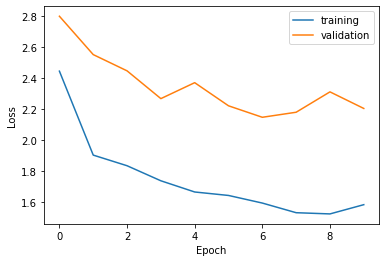

In [40]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

This model is definitely underfit. One reason is that our batch size is 1. This is a side-effect of making the number of atoms variable and then Keras/tensorflow has trouble batching together our data if there are two unknown dimensions. A standard trick is to group together multiple molecules into one graph, but making sure they are disconnected. That allows you to batch molecules without increasing the rank of your model/data.

Let’s now check the parity plot.

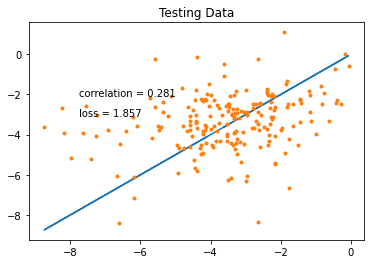

In [41]:
yhat = model.predict(test_data.batch(1), verbose=0)[:, 0]
test_y = [y for x, y in test_data]
plt.figure()
plt.plot(test_y, test_y, "-")
plt.plot(test_y, yhat, ".")
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.title("Testing Data")
plt.show()

## 5. Readout Function

GNNs output a graph by design. It is rare that our labels are graphs – typically we have node labels or a single graph label. An example of a **node label** is partial charge of atoms. An example of a graph label would be the energy of the molecule. The process of converting the graph output from the GNN into our predicted node labels or graph label is called the readout. If we have node labels, we can simply discard the edges and use our output node feature vectors from the GNN as the prediction, perhaps with a few dense layers before our predicted output label.

If we’re trying to predict a **graph-level label** like energy of the molecule or net charge, we need to be careful when converting from node/edge features to a graph label. If we simply put the node features into a dense layer to get to the desired shape graph label, we will lose permutation equivariance (technically it’s permutation invariance now since our output is graph label, not node labels). The readout we did above in the solubility example was a reduction over the node features to get a graph feature. Then we used this graph feature in dense layers. It turns out this is the only way to do a graph feature readout: a reduction over nodes to get graph feature and then dense layers to get predicted graph label from those graph features. You can also do some dense layers on the node features individually, but that already happens in GNN so I do not recommend it. This readout is sometimes called DeepSets because it is the same form as the DeepSets architecture, which is a permutation invariant architecture for features that are sets.

### 5.1. Intensive vs Extensive

One important consideration of a readout in regression is if your labels are **intensive** or **extensive**. An intensive label is one whose value is independent of the number of nodes (or atoms). For example, the index of refraction or solubility are intensive. The readout for an intensive label should (generally) be independent of the number of a nodes/atoms. So the reduction in the readout could be a mean or max, but not a sum. In contrast, an extensive label should (generally) use a sum for the reduction in the readout. An example of an extensive molecular property is enthalpy of formation.

## 6. Battaglia General Equations

[See here](https://dmol.pub/dl/gnn.html#battaglia-general-equations)

## 7. SchNet Architecture

[See here](https://dmol.pub/dl/gnn.html#the-schnet-architecture)

### 7.1. SchNet Example

Our next example will be a SchNet model that predict space groups of points. Identifying the space group of atoms is an important part of crystal structure identification, and when doing simulations of crystallization. Our SchNet model will take as input points and output the predicted space group. This is a classification problem; specifically it is multi-class becase a set of points should only be in one space group. To simplify our plots and analysis, we will work in 2D where there are 17 possible space groups.

Our data for this is a set of points from various point groups. The features are xyz coordinates and the label is the space group. We will not have multiple atom types for this problem. The cell below loads the data and reshapes it for the example.

In [43]:
import gzip
import pickle
import urllib

urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/master/data/sym_trajs.pb.gz",
    "sym_trajs.pb.gz",
)
with gzip.open("sym_trajs.pb.gz", "rb") as f:
    trajs = pickle.load(f)

label_str = list(set([k.split("-")[0] for k in trajs]))

# now build dataset
def generator():
    for k, v in trajs.items():
        ls = k.split("-")[0]
        label = label_str.index(ls)
        traj = v
        for i in range(traj.shape[0]):
            yield traj[i], label


data = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    ),
).shuffle(1000)

# The shuffling above is really important because this dataset is in order of labels!

val_data = data.take(100)
test_data = data.skip(100).take(100)
train_data = data.skip(200)

Let's see some examples of the data

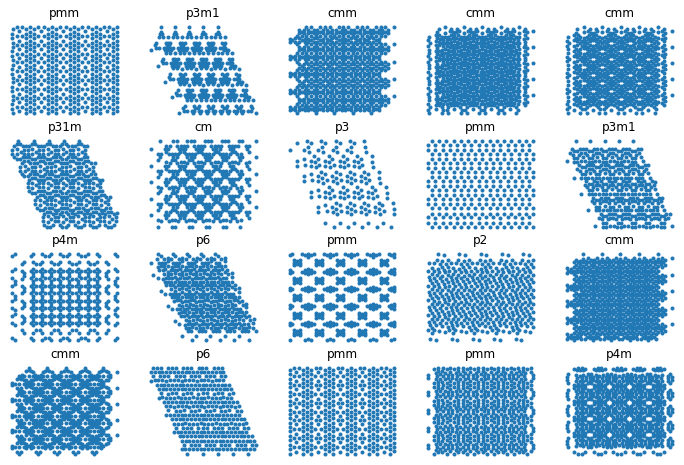

In [44]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

# get a few example and plot them
for i, (x, y) in enumerate(data):
    if i == 20:
        break
    axs[i].plot(x[:, 0], x[:, 1], ".")
    axs[i].set_title(label_str[y.numpy()])
    axs[i].axis("off")

You can see that there is a variable number of points and a few examples for each space group. The goal is to infer those titles on the plot from the points alone.

#### 7.1.1. Building the graphs

The nodes are all identical - so they can just be 1s (we’ll reserve 0 in case we want to mask or pad at some point in the future). As described in the SchNet section above, the edges should be distance to every other atom. In most implementations of SchNet, we practically add a cut-off on either distance or maximum degree (edges per node). We’ll do maximum degree for this work of 16.

I have a function below that is a bit sophisticated. It takes a matrix of point positions in arbitrary dimension and returns the distances and indices to the nearest k neighbors - exactly what we need. It uses some tricks from Tensors and Shapes. However, it is not so important for you to understand this function. Just know it takes in points and gives us the edge features and edge nodes.

In [46]:
# this decorator speeds up the function by "compiling" it (tracing it)
# to run efficienty
def get_edges(positions, NN, sorted=True):
    M = tf.shape(input=positions)[0]
    # adjust NN
    NN = tf.minimum(NN, M)
    qexpand = tf.expand_dims(positions, 1)  # one column
    qTexpand = tf.expand_dims(positions, 0)  # one row
    # repeat it to make matrix of all positions
    qtile = tf.tile(qexpand, [1, M, 1])
    qTtile = tf.tile(qTexpand, [M, 1, 1])
    # subtract them to get distance matrix
    dist_mat = qTtile - qtile
    # mask distance matrix to remove zros (self-interactions)
    dist = tf.norm(tensor=dist_mat, axis=2)
    mask = dist >= 5e-4
    mask_cast = tf.cast(mask, dtype=dist.dtype)
    # make masked things be really far
    dist_mat_r = dist * mask_cast + (1 - mask_cast) * 1000
    topk = tf.math.top_k(-dist_mat_r, k=NN, sorted=sorted)
    return -topk.values, topk.indices

Let's see the neighbor connections of some of the atoms of the grid.

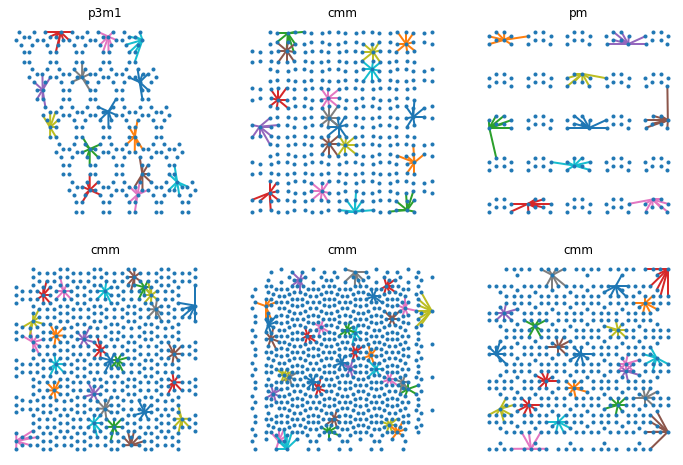

In [48]:
from matplotlib import collections

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
for i, (x, y) in enumerate(data):
    if i == 6:
        break
    e_f, e_i = get_edges(x, 8)

    # make things easier for plotting
    e_i = e_i.numpy()
    x = x.numpy()
    y = y.numpy()

    # make lines from origin to its neigbhors
    lines = []
    colors = []
    for j in range(0, x.shape[0], 23):
        # lines are [(xstart, ystart), (xend, yend)]
        lines.extend([[(x[j, 0], x[j, 1]), (x[k, 0], x[k, 1])] for k in e_i[j]])
        colors.extend([f"C{j}"] * len(e_i[j]))
    lc = collections.LineCollection(lines, linewidths=2, colors=colors)
    axs[i].add_collection(lc)
    axs[i].plot(x[:, 0], x[:, 1], ".")
    axs[i].axis("off")
    axs[i].set_title(label_str[y])
plt.show()

We will now add this function and the edge featurization of SchNet to get the graphs for the GNN steps

In [50]:
MAX_DEGREE = 16
EDGE_FEATURES = 8
MAX_R = 20

gamma = 1
mu = np.linspace(0, MAX_R, EDGE_FEATURES)


def rbf(r):
    return tf.exp(-gamma * (r[..., tf.newaxis] - mu) ** 2)


def make_graph(x, y):
    edge_r, edge_i = get_edges(x, MAX_DEGREE)
    edge_features = rbf(edge_r)
    return (tf.ones(tf.shape(x)[0], dtype=tf.int32), edge_features, edge_i), y[None]


graph_train_data = train_data.map(make_graph)
graph_val_data = val_data.map(make_graph)
graph_test_data = test_data.map(make_graph)

Let’s examine one graph to see what it looks like. We’ll slice out only the first nodes.

In [51]:
for (n, e, nn), y in graph_train_data:
    print("first node:", n[1].numpy())
    print("first node, first edge features:", e[1, 1].numpy())
    print("first node, all neighbors", nn[1].numpy())
    print("label", y.numpy())
    break

first node: 1
first node, first edge features: [2.4260104e-01 6.2098503e-02 1.2904694e-09 2.1771782e-24 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
first node, all neighbors [ 15 219 216   3 222  13 133 130 134 132 153   0 234 218 137 236]
label [7]


#### 7.1.2. Implementing the MLPs

Now we can implement the SchNet model! Let’s start with the $h_1,h_2,h_3$ Multilayer Perceptrons (MLPs) that are used in the GNN update equations. In the SchNet paper these each had different numbers of layers and different decisions about which layers had activation. Let’s create them now.

In [52]:
def ssp(x):
    # shifted softplus activation
    return tf.math.log(0.5 * tf.math.exp(x) + 0.5)


def make_h1(units):
    return tf.keras.Sequential([tf.keras.layers.Dense(units)])


def make_h2(units):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Dense(units, activation=ssp),
            tf.keras.layers.Dense(units, activation=ssp),
        ]
    )


def make_h3(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp), tf.keras.layers.Dense(units)]
    )

One detail that can be missed is that the weights in each MLP should change in each layer of SchNet. Thus, we’ve written the functions above to always return a new MLP. This means that a new set of trainable weights is generated on each call, meaning there is no way we could erroneously have the same weights in multiple layers.

#### 7.1.4. Implementing the GNN

Now we have all the pieces to make the GNN. This code will be very similar to the GCN example above, except we now have edge features. One more detail is that our readout will be an MLP as well, following the SchNet paper. The only change we’ll make is that we want our output property to be (1) multi-class classification and (2) intensive (independent of number of atoms). So we’ll end with an average (intensive) and end with an output vector of logits the size of our labels.

In [53]:
class SchNetModel(tf.keras.Model):
    """Implementation of SchNet Model"""

    def __init__(self, gnn_blocks, channels, label_dim, **kwargs):
        super(SchNetModel, self).__init__(**kwargs)
        self.gnn_blocks = gnn_blocks

        # build our layers
        self.embedding = tf.keras.layers.Embedding(2, channels)
        self.h1s = [make_h1(channels) for _ in range(self.gnn_blocks)]
        self.h2s = [make_h2(channels) for _ in range(self.gnn_blocks)]
        self.h3s = [make_h3(channels) for _ in range(self.gnn_blocks)]
        self.readout_l1 = tf.keras.layers.Dense(channels // 2, activation=ssp)
        self.readout_l2 = tf.keras.layers.Dense(label_dim)

    def call(self, inputs):
        nodes, edge_features, edge_i = inputs
        # turn node types as index to features
        nodes = self.embedding(nodes)
        for i in range(self.gnn_blocks):
            # get the node features per edge
            v_sk = tf.gather(nodes, edge_i)
            # Compute edge update
            e_k = self.h1s[i](v_sk) * self.h2s[i](edge_features)
            # Aggregation of edges updates
            e_i = tf.reduce_sum(e_k, axis=1)
            nodes += self.h3s[i](e_i)
        # readout now
        nodes = self.readout_l1(nodes)
        nodes = self.readout_l2(nodes)
        return tf.reduce_mean(nodes, axis=0)


Let's try the model with some data

In [57]:
small_schnet = SchNetModel(3, 32, len(label_str))
for x, y in graph_train_data:
    yhat = small_schnet(x)
    break  # One iteration only
print(yhat.numpy())

[ 0.01537608  0.01004084  0.00062043 -0.00364213 -0.00879848 -0.01867366
 -0.00116584  0.00050502  0.00499291 -0.01131205 -0.01954789  0.01172009
  0.00949456  0.00926934  0.02677443  0.03142727  0.00180863]


The output is the correct shape and remember it is logits. To get a class prediction that sums to probability 1, we need to use a softmax:

In [58]:
print("predicted class", tf.nn.softmax(yhat).numpy())

predicted class [0.05952293 0.05920621 0.05865108 0.05840161 0.05810125 0.05753031
 0.05854641 0.05864431 0.05890809 0.05795539 0.05748004 0.05930572
 0.05917387 0.05916055 0.06020528 0.06048606 0.05872081]


#### 7.1.5. Training

Great! It is untrained though. Now we can set-up training. Our loss will be cross-entropy from logits, but we need to be careful on the form. Our labels are integers - which is called “sparse” labels because they are not full one-hots. Mult-class classification is also known as categorical classification. Thus, the loss we want is sparse categorical cross entropy from logits.

In [59]:
small_schnet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics="sparse_categorical_accuracy",
)
result = small_schnet.fit(graph_train_data, validation_data=graph_val_data, epochs=20)

Epoch 1/20


/home/eloi/.local/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sch_net_model_2/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sch_net_model_2/Reshape_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/sch_net_model_2/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/eloi/.local/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sch_net_model_2/Reshape_6:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sch_net_model_2/Reshape_5:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/sch_net_model_2/Cast_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume

1550/1550 [==============================] - 74s 46ms/step - loss: 2.7691 - sparse_categorical_accuracy: 0.0935 - val_loss: 2.6876 - val_sparse_categorical_accuracy: 0.1800
Epoch 2/20
1550/1550 [==============================] - 65s 42ms/step - loss: 2.6990 - sparse_categorical_accuracy: 0.1026 - val_loss: 2.6486 - val_sparse_categorical_accuracy: 0.1500
Epoch 3/20
1550/1550 [==============================] - 63s 41ms/step - loss: 2.6678 - sparse_categorical_accuracy: 0.1161 - val_loss: 2.6532 - val_sparse_categorical_accuracy: 0.1500
Epoch 4/20
1550/1550 [==============================] - 63s 41ms/step - loss: 2.6491 - sparse_categorical_accuracy: 0.1226 - val_loss: 2.6970 - val_sparse_categorical_accuracy: 0.1500
Epoch 5/20
1550/1550 [==============================] - 62s 40ms/step - loss: 2.6493 - sparse_categorical_accuracy: 0.1361 - val_loss: 2.6557 - val_sparse_categorical_accuracy: 0.1100
Epoch 6/20
1550/1550 [==============================] - 71s 46ms/step - loss: 2.6347 - spar

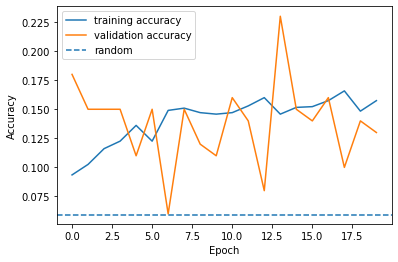

In [60]:
plt.plot(result.history["sparse_categorical_accuracy"], label="training accuracy")
plt.plot(result.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.axhline(y=1 / 17, linestyle="--", label="random")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

[Continue discussion](https://dmol.pub/dl/gnn.html#training)

## Summary
- Molecules can be represented by graphs by using one-hot encoded feature vectors that show the elemental identity of each node (atom) and an adjacency matrix that show immediate neighbors (bonded atoms).
- Graph neural networks are a category of deep neural networks that have graphs as inputs.
- One of the early GNNs is the Kipf & Welling GCN. The input to the GCN is the node feature vector and the adjacency matrix, and returns the updated node feature vector. The GCN is permutation invariant because it averages over the neighbors.
- A GCN can be viewed as a message-passing layer, in which we have senders and receivers. Messages are computed from neighboring nodes, which when aggregated update that node.
- A gated graph neural network is a variant of the message passing layer, for which the nodes are updated according to a gated recurrent unit function.
- The aggregation of messages is sometimes called pooling, for which there are multiple reduction operations.
- GNNs output a graph. To get a per-atom or per-molecule property, use a readout function. The readout depends on if your property is intensive vs extensive
- The Battaglia equations encompasses almost all GNNs into a set of 6 update and aggregation equations.
- You can convert xyz coordinates into a graph and use a GNN like SchNet
